# CNN para materia de aprendizaje profundo.
## Red Neuronal para identificar si es un perro, un gato o una gallina
### Traemos las librerias necesarias


In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt


### Preparamos las imagenes

In [2]:
base_dir = "./" 
categories = ["dogs", "cats", "chicken"] 
# Diccionario de categorías para convertir etiquetas numéricas a nombres
category_names = {0: "dogs", 1: "cats", 2: "chickens"}

img_size = 256 #Escogemos el tamaño al que adaptaremos las imagenes

In [3]:
# Función para cargar imágenes desde carpetas
def load_images_from_folders(base_dir, categories, img_size):
    data = []
    labels = []
    for label, category in enumerate(categories):
        folder_path = os.path.join(base_dir, category)
        for img_name in os.listdir(folder_path):
            try:
                # Cargar imagen
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (img_size, img_size))  # Redimensionar
                data.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error al procesar {img_name}: {e}")
    return np.array(data), np.array(labels)

In [4]:
# Cargar las imágenes
X, y = load_images_from_folders(base_dir, categories, img_size)

In [5]:
# Normalizar los valores de los píxeles (0 a 1)
X = X / 255.0

In [6]:
# Dividir en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir las formas de los datos
print(f"Tamaño de datos de entrenamiento: {X_train.shape}")
print(f"Tamaño de datos de validación: {X_val.shape}")

Tamaño de datos de entrenamiento: (120, 256, 256, 3)
Tamaño de datos de validación: (30, 256, 256, 3)


In [7]:
# Crear el modelo de la CNN con Input
model = Sequential([
    # Definir la forma de entrada explícitamente
    Input(shape=(256, 256, 3)),

    # Primera capa de convolución + MaxPooling
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Segunda capa de convolución + MaxPooling
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Tercera capa de convolución + MaxPooling
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Aplanar los datos
    Flatten(),

    # Capa densa completamente conectada
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularización para evitar overfitting

    # Capa de salida
    Dense(3, activation='softmax')  # 3 clases: dogs, cats, chickens
])

In [8]:

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,363 (56.61 MB)

 Trainable params: 14,839,363 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Callback para mostrar predicciones durante el entrenamiento
def show_predictions(epoch, logs):
    predictions = model.predict(X_val[:5])  # Hacer predicciones para las primeras 5 imágenes
    predicted_classes = np.argmax(predictions, axis=1)  # Obtener las clases predichas
    print(f"\nÉpoca {epoch + 1}:")
    for i in range(5):
        print(f"Real: {category_names[y_val[i]]}, Predicción: {category_names[predicted_classes[i]]}")


In [10]:
predictions_callback = LambdaCallback(on_epoch_end=show_predictions)

In [11]:
# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=[predictions_callback]
)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/stepaccuracy: 0.3198 - loss: 3.26

Época 1:
Real: cats, Predicción: cats
Real: dogs, Predicción: dogs
Real: chickens, Predicción: dogs
Real: cats, Predicción: cats
Real: cats, Predicción: cats
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3242 - loss: 3.3134 - val_accuracy: 0.3667 - val_loss: 1.2217
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step accuracy: 0.3521 - loss: 1.208

Época 2:
Real: cats, Predicción: cats
Real: dogs, Predicción: chickens
Real: chickens, Predicción: chickens
Real: cats, Predicción: chickens
Real: cats, Predicción: cats
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3467 - loss: 1.1990 - val_accuracy: 0.6667 - val_loss: 0.9664
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/stepaccuracy: 0.6549 - loss: 0.94

Época 3:
Real: cats, Predicción: cats
Real: dogs, Predicción: dogs
Real: chickens, Predicción: chickens
Real: cats, Predicción: dogs
Real: cats, Predicción: cats
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accurac

In [12]:
# Evaluar el modelo
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Pérdida en validación: {val_loss}")
print(f"Precisión en validación: {val_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.6667 - loss: 0.6959
Pérdida en validación: 0.6958929300308228
Precisión en validación: 0.6666666865348816


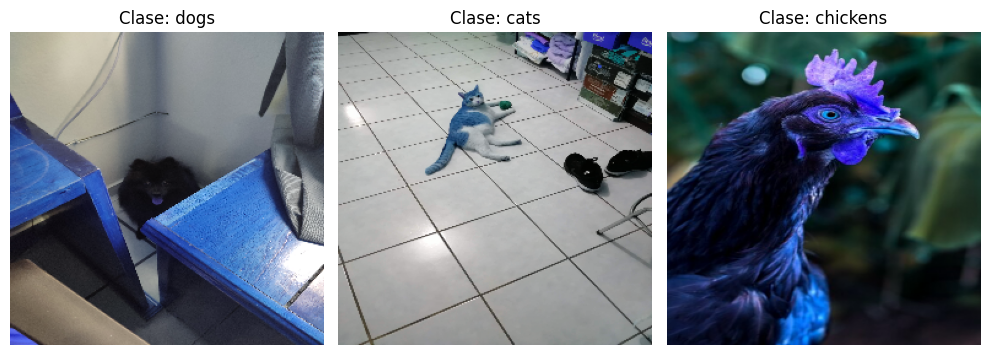

In [13]:
def plot_sample_images(X, y, category_names):
    plt.figure(figsize=(10, 5))
    for i in range(3):  
        idx = np.where(y == i)[0][0] 
        plt.subplot(1, 3, i + 1)
        plt.imshow(X[idx])
        plt.title(f"Clase: {category_names[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
plot_sample_images(X_train, y_train, category_names)
